# Исследование датасета Google 2019 Cluster Sample Dataset (Kaggle)

### Целью исследования является анализ зависимости отказов серверных инстансов от метрик нагрузки процессора, памяти и характеристик выполнения инструкций, а также подготовка данных для построения модели прогнозирования отказов.

In [65]:
import pandas as pd

In [66]:
df = pd.read_csv('borg_traces_data.csv', index_col=0)

In [67]:
df

,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request,...,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,2,94591244395,3,1,200,0,144,168846390496,"{'cpus': 0.020660400390625, 'memory': 0.014434...",...,0.014435,0.000415,NaN,NaN,1.000000,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1
1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,"{'cpus': 0.00724029541015625, 'memory': 0.0013...",...,0.000000,0.000000,NaN,NaN,1.000000,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1
2,195684022913,6,276227177776,2,0,103,0,376,169321752432,"{'cpus': 0.048583984375, 'memory': 0.004165649...",...,0.010422,0.000235,0.939919,0.001318,1.000000,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0
3,0,2,10507389885,3,0,200,0,1977,178294817221,"{'cpus': 0.0704345703125, 'memory': 0.04162597...",...,0.041626,0.000225,1.359102,0.007643,1.000000,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1
4,1810627494172,3,25911621841,2,0,0,0,3907,231364893292,"{'cpus': 0.00244903564453125, 'memory': 0.0002...",...,0.000272,0.000010,NaN,NaN,1.000000,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405889,0,2,299950285958,1,0,117,0,1341,10625460233,"{'cpus': 0.03594970703125, 'memory': 0.0154876...",...,0.002117,0.000048,0.693324,0.003158,1.000000,[0.00022793 0.00822449 0.00866699 0.01246643 0...,[0.0222168 0.02261353 0.02294922 0.02404785 0...,8,FAIL,1
405890,18279167039,0,330587213089,2,0,360,330587120885,898,68669881389,"{'cpus': 0.02197265625, 'memory': 0.0013027191...",...,0.000000,0.002468,1.019433,0.001859,1.000000,[0.01028442 0.02087402 0.02432251 0.02661133 0...,[0.05828857 0.05871582 0.05938721 0.06097412 0...,1,ENABLE,0
405891,733307641549,3,13748637767,3,0,200,13748635759,1959,126641993288,"{'cpus': 0.1214599609375, 'memory': 0.08264160...",...,0.000000,0.000480,0.990970,0.002941,1.000000,[0.00857544 0.01472473 0.01660156 0.01873779 0...,[0.03515625 0.03552246 0.03729248 0.03912354 0...,2,FINISH,0
405892,1984523129238,2,323372663325,1,0,117,0,6452,191941429308,"{'cpus': 0.00566864013671875, 'memory': 0.0015...",...,0.001562,0.000229,3.023431,0.015743,0.996667,[0.00024414 0.00030136 0.00036907 0.00073719 0...,[0.00904846 0.00907898 0.00909424 0.00912476 0...,8,FAIL,1


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405894 entries, 0 to 405893
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   time                             405894 non-null  int64  
 1   instance_events_type             405894 non-null  int64  
 2   collection_id                    405894 non-null  int64  
 3   scheduling_class                 405894 non-null  int64  
 4   collection_type                  405894 non-null  int64  
 5   priority                         405894 non-null  int64  
 6   alloc_collection_id              405894 non-null  int64  
 7   instance_index                   405894 non-null  int64  
 8   machine_id                       405894 non-null  int64  
 9   resource_request                 405120 non-null  object 
 10  constraint                       405894 non-null  object 
 11  collections_events_type          405894 non-null  int64  
 12  user   

### Разбор признаков

- Целевая переменая: **failed**

- Временные признаки:
    - time
    - start_time
    - end_time

- Метрики нагрузки:
    - average_usage
    - maximum_usage
    - random_sample_usage
    - cpu_usage_distribution
    - tail_cpu_usage_distribution

    - assigned_memory
    - page_cache_memory

    - cycles_per_instruction
    - memory_accesses_per_instruction

- Индентификаторы:
    - machine_id
    - instance_index
    - collection_id
    - alloc_collection_id
    - cluster

- Оркестрация / планировщик:
    - priority
    - scheduling_class
    - collection_type
    - instance_events_type
    - collections_events_type
    - scheduler
    - event
    - vertical_scaling

- Служебные поля:
    - user
    - collection_name
    - collection_logical_name
    - constraint
    - start_after_collection_ids
    - resource_request

### Для дальнейшего исследования я выбрал следующие поля:


TARGET:
- failed

TIME:
- start_time
- end_time

CPU:
- average_usage
- maximum_usage
- cpu_usage_distribution
- tail_cpu_usage_distribution
- cycles_per_instruction

MEMORY:
- assigned_memory
- page_cache_memory
- memory_accesses_per_instruction


### Начало с таргета

In [69]:
df['failed'].value_counts()

failed
0    313216
1     92678
Name: count, dtype: int64

In [70]:
df['failed'].value_counts(normalize=True)

failed
0    0.771669
1    0.228331
Name: proportion, dtype: float64

Анализ распределения целевой переменной показал выраженный дисбаланс классов, что характерно для задач прогнозирования отказов оборудования

### Обработка столбцов

In [71]:
drop_cols = [
    'time','start_time','end_time',
    'machine_id','instance_index','collection_id','alloc_collection_id','cluster',
    'instance_events_type','collections_events_type','event','scheduler',
    'vertical_scaling','scheduling_class','collection_type','priority',
    'user','collection_name','collection_logical_name',
    'constraint','start_after_collection_ids','resource_request'
]

In [72]:
df['duration'] = df['end_time'] - df['start_time']

In [73]:
df = df.drop(columns=drop_cols)

In [74]:
df

,average_usage,maximum_usage,random_sample_usage,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,failed,duration
0,"{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356...","{'cpus': 0.0043487548828125, 'memory': None}",0.014435,0.000415,NaN,NaN,1.000000,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,1,300000000
1,"{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': None}",0.000000,0.000000,NaN,NaN,1.000000,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,1,1000000
2,"{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641...","{'cpus': 0.026458740234375, 'memory': None}",0.010422,0.000235,0.939919,0.001318,1.000000,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,0,300000000
3,"{'cpus': 0.047607421875, 'memory': 0.034423828...","{'cpus': 0.13330078125, 'memory': 0.03466796875}","{'cpus': 0.05084228515625, 'memory': None}",0.041626,0.000225,1.359102,0.007643,1.000000,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,1,300000000
4,"{'cpus': 0.000270843505859375, 'memory': 7.629...","{'cpus': 0.00041484832763671875, 'memory': 7.6...","{'cpus': 0.0003414154052734375, 'memory': None}",0.000272,0.000010,NaN,NaN,1.000000,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,0,2000000
...,...,...,...,...,...,...,...,...,...,...,...,...
405889,"{'cpus': 0.01531982421875, 'memory': 0.0015010...","{'cpus': 0.04833984375, 'memory': 0.0018024444...","{'cpus': 0.0150604248046875, 'memory': None}",0.002117,0.000048,0.693324,0.003158,1.000000,[0.00022793 0.00822449 0.00866699 0.01246643 0...,[0.0222168 0.02261353 0.02294922 0.02404785 0...,1,300000000
405890,"{'cpus': 0.03814697265625, 'memory': 0.0199890...","{'cpus': 0.091796875, 'memory': 0.020477294921...","{'cpus': 0.03375244140625, 'memory': None}",0.000000,0.002468,1.019433,0.001859,1.000000,[0.01028442 0.02087402 0.02432251 0.02661133 0...,[0.05828857 0.05871582 0.05938721 0.06097412 0...,0,300000000
405891,"{'cpus': 0.0235595703125, 'memory': 0.07580566...","{'cpus': 0.0625, 'memory': 0.0758056640625}","{'cpus': 0.014373779296875, 'memory': None}",0.000000,0.000480,0.990970,0.002941,1.000000,[0.00857544 0.01472473 0.01660156 0.01873779 0...,[0.03515625 0.03552246 0.03729248 0.03912354 0...,0,300000000
405892,"{'cpus': 0.00600433349609375, 'memory': 0.0009...","{'cpus': 0.0184326171875, 'memory': 0.00138092...","{'cpus': 0.0088043212890625, 'memory': None}",0.001562,0.000229,3.023431,0.015743,0.996667,[0.00024414 0.00030136 0.00036907 0.00073719 0...,[0.00904846 0.00907898 0.00909424 0.00912476 0...,1,300000000


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405894 entries, 0 to 405893
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   average_usage                    405894 non-null  object 
 1   maximum_usage                    405894 non-null  object 
 2   random_sample_usage              405894 non-null  object 
 3   assigned_memory                  405894 non-null  float64
 4   page_cache_memory                405894 non-null  float64
 5   cycles_per_instruction           281206 non-null  float64
 6   memory_accesses_per_instruction  281206 non-null  float64
 7   sample_rate                      405894 non-null  float64
 8   cpu_usage_distribution           405894 non-null  object 
 9   tail_cpu_usage_distribution      405894 non-null  object 
 10  failed                           405894 non-null  int64  
 11  duration                         405894 non-null  int64  
dtypes: floa

На этапе предварительного анализа исходного датасета были исключены служебные, идентификационные и организационные признаки, не отражающие фактическое состояние серверного оборудования. Для дальнейшего исследования были отобраны метрики, характеризующие загрузку процессора, использование памяти и временные характеристики выполнения инстансов. Такой подход позволил сосредоточиться на параметрах, непосредственно влияющих на вероятность отказа оборудования, и упростить интерпретацию результатов.

### Разбор столбцов с dist и list

In [76]:
import ast
import numpy as np

In [77]:
def extract_cpu_mem(x, key):
    if pd.isna(x):
        return np.nan
    d = ast.literal_eval(x)
    return d.get(key, np.nan)

In [78]:
df['avg_cpu_usage'] = df['average_usage'].apply(lambda x: extract_cpu_mem(x, 'cpus'))
df['avg_memory_usage'] = df['average_usage'].apply(lambda x: extract_cpu_mem(x, 'memory'))

df['max_cpu_usage'] = df['maximum_usage'].apply(lambda x: extract_cpu_mem(x, 'cpus'))
df['max_memory_usage'] = df['maximum_usage'].apply(lambda x: extract_cpu_mem(x, 'memory'))

In [ ]:
def parse_array(x):
    if pd.isna(x):
        return None

    if isinstance(x, str):
        return np.fromstring(
            x.strip('[]'),
            sep=' ',
            dtype=float
        )

    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)

    return None

In [80]:
def extract_stats(x):
    arr = parse_array(x)
    if arr is None or arr.size == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    return (
        arr.mean(),
        arr.std(),
        arr.min(),
        arr.max(),
        np.percentile(arr, 95)
    )

In [81]:
stats = df['cpu_usage_distribution'].apply(extract_stats)

df[['cpu_mean','cpu_std','cpu_min','cpu_max','cpu_p95']] = pd.DataFrame(stats.tolist(), index=df.index)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405894 entries, 0 to 405893
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   average_usage                    405894 non-null  object 
 1   maximum_usage                    405894 non-null  object 
 2   random_sample_usage              405894 non-null  object 
 3   assigned_memory                  405894 non-null  float64
 4   page_cache_memory                405894 non-null  float64
 5   cycles_per_instruction           281206 non-null  float64
 6   memory_accesses_per_instruction  281206 non-null  float64
 7   sample_rate                      405894 non-null  float64
 8   cpu_usage_distribution           405894 non-null  object 
 9   tail_cpu_usage_distribution      405894 non-null  object 
 10  failed                           405894 non-null  int64  
 11  duration                         405894 non-null  int64  
 12  avg_cpu

In [83]:
drop_cols = [
    'average_usage',
    'maximum_usage',
    'random_sample_usage',
    'cpu_usage_distribution',
    'tail_cpu_usage_distribution',
    'sample_rate',
    'cpu_min'
]

In [84]:
df = df.drop(columns=drop_cols)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405894 entries, 0 to 405893
Data columns (total 14 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   assigned_memory                  405894 non-null  float64
 1   page_cache_memory                405894 non-null  float64
 2   cycles_per_instruction           281206 non-null  float64
 3   memory_accesses_per_instruction  281206 non-null  float64
 4   failed                           405894 non-null  int64  
 5   duration                         405894 non-null  int64  
 6   avg_cpu_usage                    405894 non-null  float64
 7   avg_memory_usage                 405894 non-null  float64
 8   max_cpu_usage                    405894 non-null  float64
 9   max_memory_usage                 400967 non-null  float64
 10  cpu_mean                         390219 non-null  float64
 11  cpu_std                          390219 non-null  float64
 12  cpu_max

In [86]:
df.isna().mean().sort_values(ascending=False)

memory_accesses_per_instruction    0.307194
cycles_per_instruction             0.307194
cpu_mean                           0.038618
cpu_std                            0.038618
cpu_max                            0.038618
cpu_p95                            0.038618
max_memory_usage                   0.012139
failed                             0.000000
assigned_memory                    0.000000
page_cache_memory                  0.000000
duration                           0.000000
max_cpu_usage                      0.000000
avg_cpu_usage                      0.000000
avg_memory_usage                   0.000000
dtype: float64

После выполнения этапа извлечения признаков исходные структурированные поля, представленные в виде словарей и массивов, были исключены из датасета. Для дальнейшего анализа использовались только числовые признаки, отражающие среднюю, пиковую и вариационную нагрузку процессора, использование памяти и временные характеристики выполнения инстансов. Такой подход позволил уменьшить размерность данных, повысить интерпретируемость модели и снизить вычислительную сложность.

### Полученный набор столбцов

TARGET:
- failed

FEATURES:
- duration

CPU:
- avg_cpu_usage
- max_cpu_usage
- cpu_mean
- cpu_std
- cpu_max
- cpu_p95

Memory:
- avg_memory_usage
- max_memory_usage
- assigned_memory
- page_cache_memory

Architecture:
- cycles_per_instruction
- memory_accesses_per_instruction

### Заполняем пропуски

In [87]:
high_missing_cols = [
    'cycles_per_instruction',
    'memory_accesses_per_instruction'
]

for col in high_missing_cols:
    df[f'{col}_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(df[col].median())

In [88]:
low_missing_cols = [
    'cpu_mean',
    'cpu_std',
    'cpu_max',
    'cpu_p95',
    'max_memory_usage'
]

for col in low_missing_cols:
    df[col] = df[col].fillna(df[col].median())

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405894 entries, 0 to 405893
Data columns (total 16 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   assigned_memory                          405894 non-null  float64
 1   page_cache_memory                        405894 non-null  float64
 2   cycles_per_instruction                   405894 non-null  float64
 3   memory_accesses_per_instruction          405894 non-null  float64
 4   failed                                   405894 non-null  int64  
 5   duration                                 405894 non-null  int64  
 6   avg_cpu_usage                            405894 non-null  float64
 7   avg_memory_usage                         405894 non-null  float64
 8   max_cpu_usage                            405894 non-null  float64
 9   max_memory_usage                         405894 non-null  float64
 10  cpu_mean                             

Пропуски в архитектурных счётчиках процессора носят системный характер и связаны с особенностями сбора телеметрии, поэтому факт их отсутствия может нести дополнительную информацию. В связи с этим для таких признаков использовалась медианная импутация с добавлением бинарного индикатора отсутствия. Для остальных признаков, имеющих малую долю пропусков, применялась стандартная медианная импутация.

### Анализ корреляции

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
target = 'failed'
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df[numeric_cols].corr()

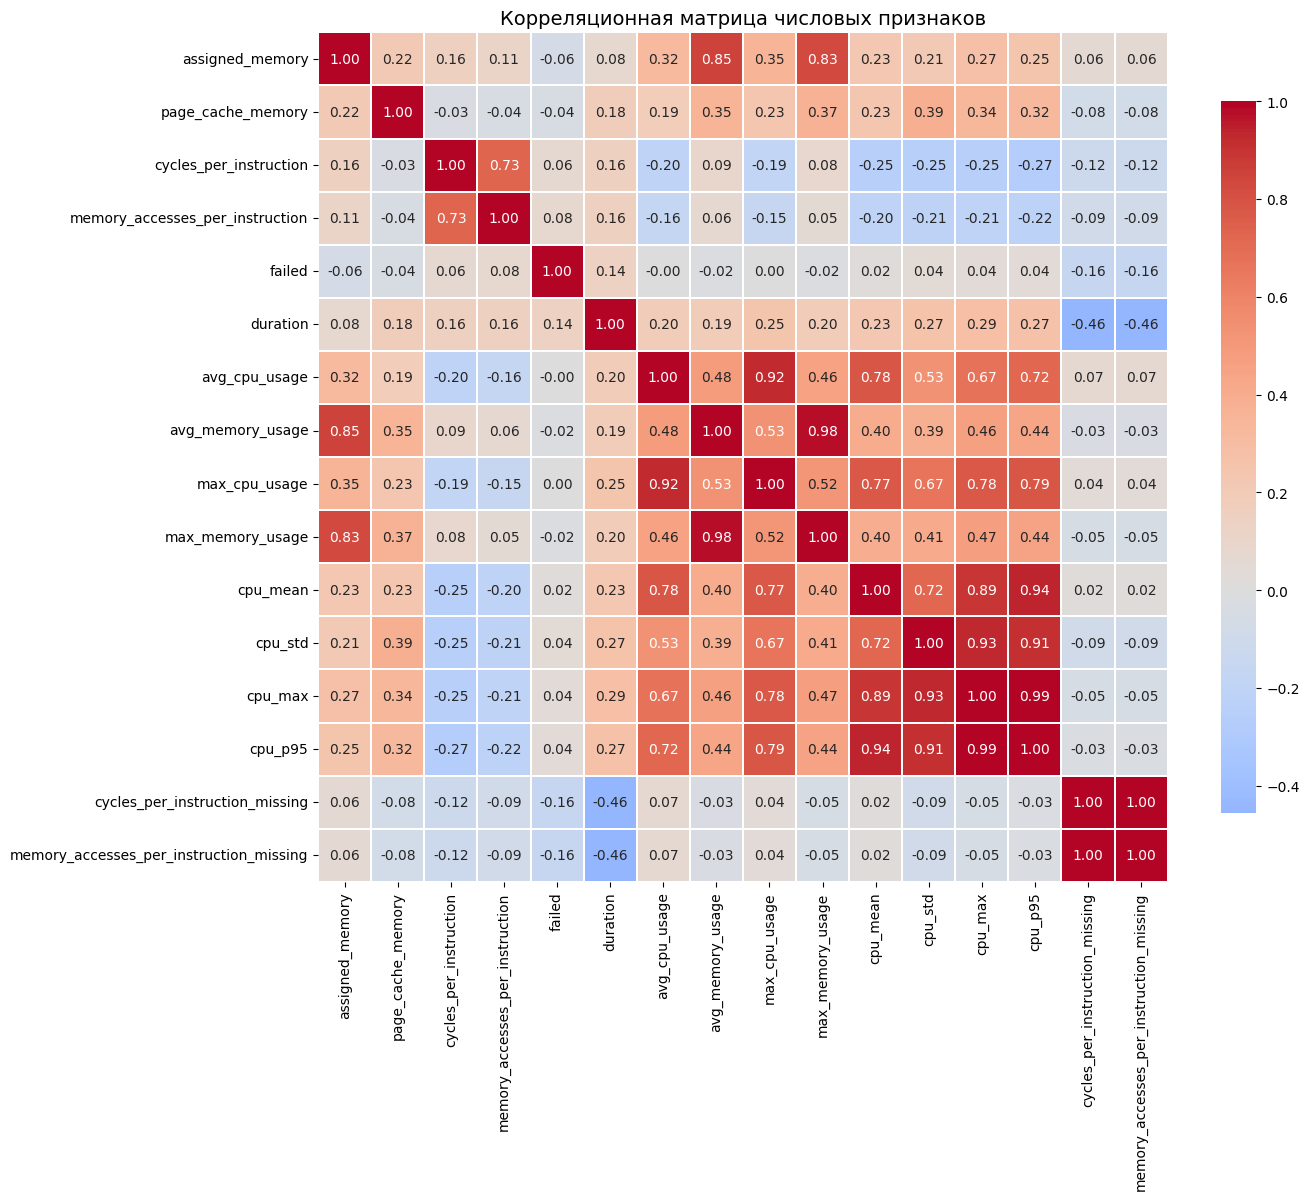

In [92]:
plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.3,
    annot=True,
    fmt=".2f",
    cbar_kws={'shrink': 0.8}
)

plt.title('Корреляционная матрица числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

In [93]:
final_features = [
    'failed',
    
    'duration',

    'avg_cpu_usage',
    'cpu_std',
    'cpu_p95',

    'assigned_memory',
    'avg_memory_usage',
    'page_cache_memory',

    'cycles_per_instruction',
    'memory_accesses_per_instruction',
    'cycles_per_instruction_missing',
    'memory_accesses_per_instruction_missing'
]

In [94]:
df = df[final_features].copy()

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405894 entries, 0 to 405893
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   failed                                   405894 non-null  int64  
 1   duration                                 405894 non-null  int64  
 2   avg_cpu_usage                            405894 non-null  float64
 3   cpu_std                                  405894 non-null  float64
 4   cpu_p95                                  405894 non-null  float64
 5   assigned_memory                          405894 non-null  float64
 6   avg_memory_usage                         405894 non-null  float64
 7   page_cache_memory                        405894 non-null  float64
 8   cycles_per_instruction                   405894 non-null  float64
 9   memory_accesses_per_instruction          405894 non-null  float64
 10  cycles_per_instruction_missing       

In [96]:
df['failed'].value_counts(normalize=True)

failed
0    0.771669
1    0.228331
Name: proportion, dtype: float64

### Итоговый набор столбцов:

TARGET:
- failed

TIME:
- duration

CPU:
- avg_cpu_usage
- cpu_std
- cpu_p95

Memory:
- assigned_memory
- avg_memory_usage
- page_cache_memory

Architecture:
- cycles_per_instruction
- memory_accesses_per_instruction
- cycles_per_instruction_missing
- memory_accesses_per_instruction_missing

Корреляционный анализ показал наличие выраженной мультиколлинеарности между рядом показателей загрузки процессора и памяти. В связи с этим на последующих этапах моделирования был выполнен отбор признаков с целью сокращения размерности данных и повышения устойчивости моделей. При этом были сохранены наиболее интерпретируемые показатели, отражающие средний уровень нагрузки, вариативность и пиковые значения, а также архитектурные счётчики и индикаторы отсутствия метрик, показавшие заметную связь с целевой переменной.

In [97]:
# output_path = 'df.csv'

# df.to_csv(
#     output_path,
#     index=False
# )

# print(f'Датасет сохранён в файл: {output_path}')